In [ ]:
import os
import numpy as np
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Mental_Foreman/Mental_Foramen_FF.zip" -d "/content/mental_foreman"

Streaming output truncated to the last 5000 lines.
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (168).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (168).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (492).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (492).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (304).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (304).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (373).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (373).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (236).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (236).jpg  
  inflating: /content/me

In [ ]:
# Preprocess the image

# -*- coding: utf-8 -*-

# import os
# import numpy as np
# from PIL import Image
# from zipfile import ZipFile
# from natsort import natsorted

path = '/content/mental_foreman/Mental_Foramen_FF/ORIGINAL/'

def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img
    
def pre_images(resize_shape,path,include_zip):
    if include_zip==True:
        ZipFile(path+"/DentalPanoramicXrays.zip").extractall(path) 
        path=path+'/Images/'
    dirs=natsorted(os.listdir(path))
    sizes=np.zeros([len(dirs),2])
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images=convert_one_channel(np.asarray(images))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))
    return images,sizes

In [ ]:
X,X_sizes=pre_images((256,256),path,False)
# print(X[0])

In [ ]:
import os
import sys
import numpy as np
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted
script_dir=os.path.abspath(os.path.dirname(sys.argv[0]))
default_path=script_dir+'/content/mental_foreman/Mental_Foramen_FF/'


In [ ]:
def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img
def pre_masks(resize_shape=(256,256),path=default_path):
    # ZipFile(path+"/Orig_Masks.zip").extractall(path+'/Masks/') 
    path=path+'/masked_images/'
    dirs=natsorted(os.listdir(path))
    masks=img=Image.open(path+dirs[0])
    masks=(masks.resize((resize_shape),Image.ANTIALIAS))
    masks=convert_one_channel(np.asarray(masks))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        masks=np.concatenate((masks,img))
    masks=np.reshape(masks,(len(dirs),resize_shape[0],resize_shape[1],1))
    return masks


In [ ]:
!find . -name ".DS_Store" -delete

In [ ]:
Y=pre_masks(resize_shape=(256,256),path='/content/mental_foreman/Mental_Foramen_FF')  #ORIGINALL MASKS function 

In [ ]:
X=np.float32(X/255)
Y=np.float32(Y/255)

In [ ]:
x_train=X[:500,:,:,:]
y_train=Y[:500,:,:,:]
x_test=X[500:,:,:,:]
y_test=Y[500:,:,:,:]


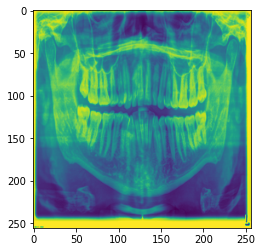

In [ ]:
import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)

plt.imshow(x_train[random_number,:,:,0])


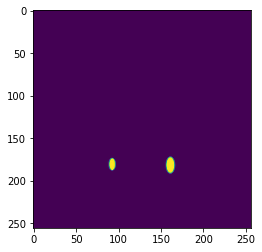

In [ ]:
plt.imshow(y_train[random_number,:,:,0])

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 10 21:42:46 2020

@author: serdarhelli
"""
#### MODEL ###
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,Conv2DTranspose,Dropout
from tensorflow.keras.models import Model


def UNET (input_shape=(512,512,1),last_activation='sigmoid'):
    inputs=Input(shape=input_shape)
    
    conv1 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    d1=Dropout(0.1)(conv1)
    conv2 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d1)
    b=BatchNormalization()(conv2)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(b)
    conv3 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    d2=Dropout(0.2)(conv3)
    conv4 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d2)
    b1=BatchNormalization()(conv4)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(b1)
    conv5 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    d3=Dropout(0.3)(conv5)
    conv6 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d3)
    b2=BatchNormalization()(conv6)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(b2)
    conv7 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    d4=Dropout(0.4)(conv7)
    conv8 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d4)
    b3=BatchNormalization()(conv8)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(b3)
    conv9 = Conv2D(512,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    d5=Dropout(0.5)(conv9)
    conv10 = Conv2D(512,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d5)
    b4=BatchNormalization()(conv10)
    
    
    conv11 = Conv2DTranspose(512,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b4)
    x= concatenate([conv11,conv8])
    conv12 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    d6=Dropout(0.4)(conv12)
    conv13 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d6)
    b5=BatchNormalization()(conv13)
    
    
    conv14 = Conv2DTranspose(256,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b5)
    x1=concatenate([conv14,conv6])
    conv15 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x1)
    d7=Dropout(0.3)(conv15)
    conv16 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d7)
    b6=BatchNormalization()(conv16)
    
    conv17 = Conv2DTranspose(128,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b6)
    x2=concatenate([conv17,conv4])
    conv18 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x2)
    d8=Dropout(0.2)(conv18)
    conv19 = Conv2D(64,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d8)
    b7=BatchNormalization()(conv19)
    
    conv20 = Conv2DTranspose(64,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b7)
    x3=concatenate([conv20,conv2])
    conv21 = Conv2D(32,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x3)
    d9=Dropout(0.1)(conv21)
    conv22 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d9)
    
    outputs = Conv2D(1,(1,1), activation = last_activation, padding = 'same', kernel_initializer = 'he_normal')(conv22)
    model2 = Model( inputs = inputs, outputs = outputs)
    
    return model2


In [ ]:
model=UNET(input_shape=(256,256,1),last_activation='sigmoid')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true) # Extend y_true to one dimension.
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [ ]:
!pip3 install keras_unet_collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 6.6 MB/s 


In [ ]:
from keras_unet_collection import models, losses
from tensorflow.keras.metrics import Precision, Recall, MeanIoU

In [ ]:
# model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer ='adam', loss = dice_coef_loss, metrics = ['accuracy', dice_coef, Recall(), Precision(), MeanIoU(num_classes=2)])

#Your choice batch and epoch 
model.fit(x_train,y_train,batch_size=4,epochs=200,verbose=1)

Epoch 1/200
125/125 [==============================] - 37s 136ms/step - loss: 0.7310 - accuracy: 0.9752 - dice_coef: 0.2690 - recall: 0.2310 - precision: 0.0479 - mean_io_u: 0.4995
Epoch 2/200
125/125 [==============================] - 17s 138ms/step - loss: 0.5285 - accuracy: 0.9943 - dice_coef: 0.4715 - recall: 0.3589 - precision: 0.4875 - mean_io_u: 0.4995
Epoch 3/200
125/125 [==============================] - 17s 139ms/step - loss: 0.3959 - accuracy: 0.9953 - dice_coef: 0.6041 - recall: 0.3491 - precision: 0.6696 - mean_io_u: 0.5053
Epoch 4/200
125/125 [==============================] - 18s 142ms/step - loss: 0.3136 - accuracy: 0.9956 - dice_coef: 0.6864 - recall: 0.4086 - precision: 0.7461 - mean_io_u: 0.5035
Epoch 5/200
125/125 [==============================] - 18s 143ms/step - loss: 0.2600 - accuracy: 0.9958 - dice_coef: 0.7400 - recall: 0.4373 - precision: 0.7995 - mean_io_u: 0.5037
Epoch 6/200
125/125 [==============================] - 18s 145ms/step - loss: 0.2274 - accuracy

In [ ]:
predict_img=model.predict(x_test[:])
##model.save(path)

In [ ]:
import matplotlib.pyplot as plt


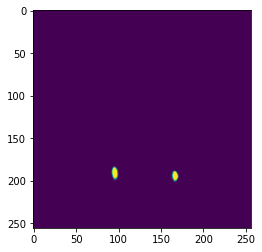

In [ ]:
plt.imshow(predict_img[7][:,:,0])

In [ ]:
count = 0
dice_sum = 0
for image, label in zip(predict_img, y_test):
    # print(count)
    # print(image.shape)
    # print(label.shape)
    dice = dice_coef(label, image)
    # print(dice)
    # print(count)
    dice_sum+= dice
    
    count+=1
dice_average = dice_sum/count
print("dice_average :",  dice_average)

dice_average : tf.Tensor(0.7650404, shape=(), dtype=float32)


In [ ]:
m = MeanIoU(num_classes=2)
m.update_state(y_test, predict_img)
print("Mean IoU :",m.result().numpy())

Mean IoU : 0.56347436
